In [1]:
pip install pytorch-lightning  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 584 kB 8.1 MB/s 
     |████████████████████████████████| 596 kB 57.1 MB/s 
     |████████████████████████████████| 418 kB 63.7 MB/s 
     |████████████████████████████████| 140 kB 72.0 MB/s 
     |████████████████████████████████| 1.1 MB 53.4 MB/s 
     |████████████████████████████████| 144 kB 72.3 MB/s 
     |████████████████████████████████| 271 kB 69.7 MB/s 
     |████████████████████████████████| 94 kB 4.2 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 127 kB 7.2 MB/s 
     |████████████████████████████████| 308 kB 60.6 MB/s 
     |████████████████████████████████| 209 kB 68.7 MB/s 
     |████████████████████████████████| 81 kB 11.9 MB/s 
     |████████████████████████████████| 78 kB 9.2 MB/s 
     |████████████████████████████████| 112 kB 77.7 MB/s 
     |████████████████████████████████| 49 kB 7.6 MB/s 
     |████████████████████████████████| 146 kB 77.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=65f98b53cf566f3b0d92636a794913e2e2ad180b69a9ed86205d3b2aa41d38fd
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [3]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
import warnings
warnings.filterwarnings('ignore')
import pickle
import numpy as np
import pandas as pd
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import pandas as pd

import torch

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor


from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, DistributionLoss, NormalDistributionLoss, LogNormalDistributionLoss

In [5]:
from pytorch_forecasting.data.encoders import GroupNormalizer
with open('/content/crypto_currency.pickle', 'rb') as f:
    data = pickle.load(f)

In [6]:
d1 = data['KRW-ZIL']
d1 = d1.sort_values('candle_date_time_kst')
d1['time_index'] = np.arange(len(d1))
date_index = d1[['time_index', 'candle_date_time_kst']]

In [7]:
res_data = pd.DataFrame()
for i, key in enumerate(data.keys()):
    tmp = data[key]
#     if tmp.shape[0] == 720:
    tmp_1 = pd.merge(tmp, date_index, on ='candle_date_time_kst')
    tmp_df_1 = tmp_1[['market', 'candle_acc_trade_volume', 'time_index', 'candle_date_time_kst', 'trade_price']]
    tmp_df_1.reset_index(inplace = True)
    try:
        res_data = pd.concat([res_data, tmp_df_1])
    except Exception as e:
        pass    

In [8]:
gn = GroupNormalizer(
    groups= ['market'],
    scale_by_group = True
)
scaled_trade_price = gn.fit_transform(res_data['trade_price'], res_data, return_norm = True)
scaled_volume = gn.fit_transform(res_data['candle_acc_trade_volume'], res_data, return_norm = True)

res_data['trade_price'] = scaled_trade_price[0]
res_data['candle_acc_trade_volume'] = scaled_volume[0]

res_data.dropna(inplace = True)
res_data.shape

(101553, 6)

In [9]:
res_data['new_idx'] = res_data['market'] + '_' + res_data['time_index'].astype(str)
res_data.drop_duplicates(subset = ['new_idx'], inplace = True)
res_data.sort_values(['market', 'time_index'], inplace = True)
res_data.set_index('new_idx', inplace = True)

In [10]:
res_data.head()

,index,market,candle_acc_trade_volume,time_index,candle_date_time_kst,trade_price
new_idx,,,,,,
BTC-AERGO_120,0,BTC-AERGO,-0.334367,120,2019-12-22T09:00:00,-0.127470
BTC-AERGO_122,1,BTC-AERGO,-0.330511,122,2019-12-24T09:00:00,-0.340098
BTC-AERGO_125,2,BTC-AERGO,-0.182656,125,2019-12-27T09:00:00,-0.552727
BTC-AERGO_126,3,BTC-AERGO,-0.331371,126,2019-12-28T09:00:00,-0.552727
BTC-AERGO_127,4,BTC-AERGO,-0.324256,127,2019-12-29T09:00:00,-0.566902


In [11]:
max_encoder_length = 40
max_prediction_length = 10
training_cutoff = res_data['time_index'].max() - max_prediction_length

In [12]:
training = TimeSeriesDataSet(
    res_data[lambda x: x.time_index < training_cutoff],
    time_idx = 'time_index',
    target = 'trade_price',
    group_ids = ['market'],
    max_encoder_length = max_encoder_length,
    max_prediction_length = max_prediction_length,
    static_categoricals = [],
    static_reals = [],
    time_varying_known_categoricals = [],
#     time_varying_known_reals = ['candle_acc_trade_volume'],
    time_varying_unknown_categoricals = [],
    time_varying_unknown_reals = ['candle_acc_trade_volume'],
    allow_missing_timesteps = True
)

In [13]:
validation = TimeSeriesDataSet.from_dataset(
                training, 
                res_data, 
                min_prediction_idx = training_cutoff + 1,
                stop_randomization = True
)

In [14]:
batch_size = 128
train_dataloader = training.to_dataloader(train = True, batch_size = batch_size, num_workers = 2)
val_dataloader = validation.to_dataloader(train = False, batch_size = batch_size, num_workers = 2)

In [15]:
# early_stop_callback = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, 
#                                     patience = 20, verbose = True, mode = 'min')
# lr_logger = LearningRateMonitor()
# trainer = pl.Trainer(
#     max_epochs = 200,
#     gpus = 1,
# #     accelerator = 'ddp',
#     gradient_clip_val = 0.1,
#     limit_train_batches = 30,
#     callbacks = [lr_logger, early_stop_callback],
#     logger = TensorBoardLogger('lightning_logs')
    
# )

In [16]:
# tft = TemporalFusionTransformer.from_dataset(
#     training,
#     # architecture hyperparameters
#     hidden_size = 16,
#     attention_head_size = 1,
#     dropout = .1,
#     hidden_continuous_size = 16,
#     loss = QuantileLoss(),
#     # log freqeuency
#     log_interval = 2,
#     # optimizer parameters
#     learning_rate = .03,
#     reduce_on_plateau_patience = 4
# )

# print(f'Number of parameters in network: {tft.size()/1e3:.1f}k')

# res = trainer.tuner.lr_find(
#     tft, train_dataloaders = train_dataloader,
#     val_dataloaders = val_dataloader,
#     early_stop_threshold = 10000.0,
#     max_lr = .3,
# )

# print(f'suggested learning rate: {res.suggestion()}')

# fig = res.plot(show = True, suggest = True)
# fig.show()

In [17]:
pl.seed_everything(42)
early_stop_callback = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, 
                                    patience = 20, verbose = False, mode = 'min')
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs = 1000,
    gpus = 1,
#     accelerator = 'ddp',
    gradient_clip_val = 0.1,
    limit_train_batches = 30,
    callbacks = [lr_logger, early_stop_callback],
    logger = TensorBoardLogger('lightning_logs')
    
)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    # architecture hyperparameters
    hidden_size = 20,
    attention_head_size = 4,
    dropout = .1,
    hidden_continuous_size = 20,
    loss = QuantileLoss(),
    # log freqeuency
    log_interval = 50,
    # optimizer parameters
    learning_rate = 1e-5,
    reduce_on_plateau_patience = 10
)

print(f'Number of parameters in network: {tft.size()/1e3:.1f}k')

Number of parameters in network: 23.0k


In [19]:
trainer.fit(
    tft, train_dataloaders = train_dataloader,
    val_dataloaders = val_dataloader,
)

Missing logger folder: lightning_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 40    
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.8 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 0     
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.7 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork      

Sanity Checking: 0it [00:00, ?it/s]

IndexError: ignored

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = tft.load_from_checkpoint(best_model_path)

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.1879)

In [ ]:
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(0.3624)

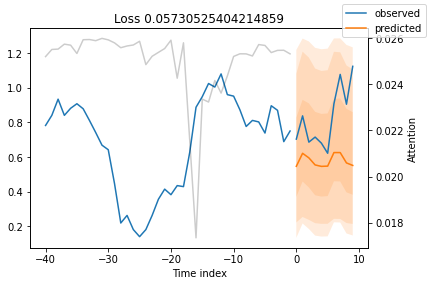

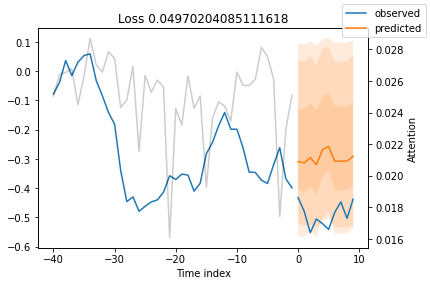

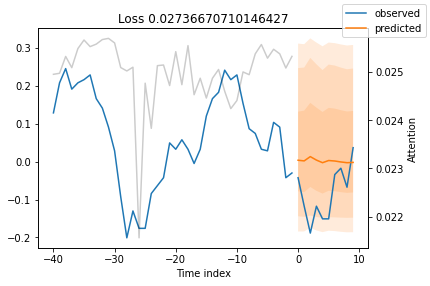

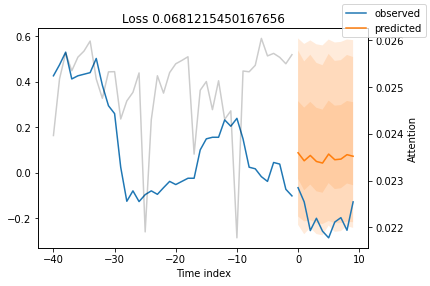

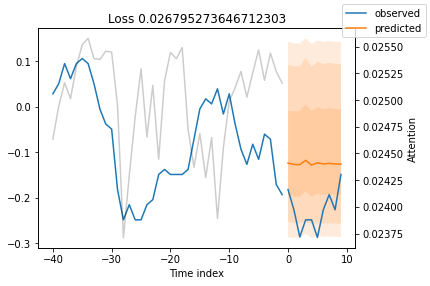

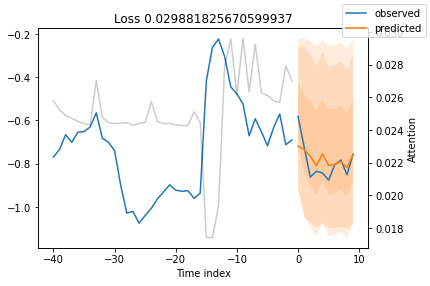

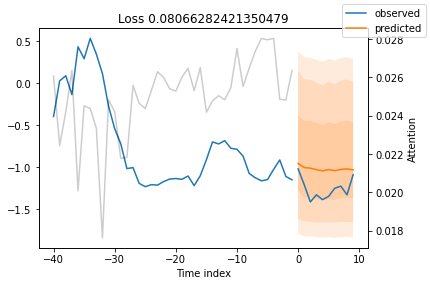

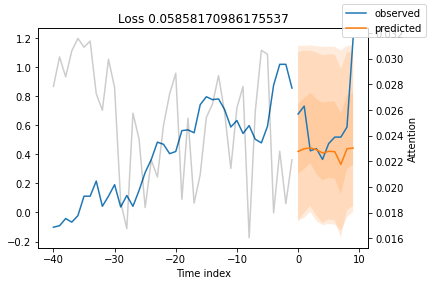

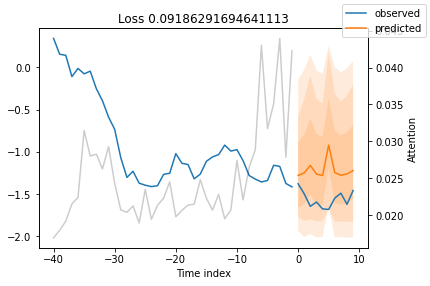

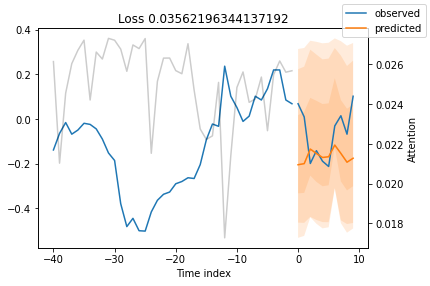

In [ ]:
raw_predictions, x = best_model.predict(val_dataloader, mode = 'raw', return_x=True)
# for idx in range(2):  # plot 10 examples
for i in np.arange(120, 130):
    best_model.plot_prediction(x, raw_predictions, idx=i, add_loss_to_title=True)